<a href="https://colab.research.google.com/github/oneoftwo/CH453_AI_chemistry/blob/main/practice_3/practice_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Practice Session 3**

In [128]:
# DO NOT CHANGE!
!rm -rf CH453*
!git clone https://github.com/oneoftwo/CH453_AI_chemistry/
!ls
!mv ./CH453_AI_chemistry/* ./
!ls
!pip install rdkit

import rdkit
print(rdkit.__version__)

Cloning into 'CH453_AI_chemistry'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 85 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (85/85), 1.68 MiB | 5.05 MiB/s, done.
Resolving deltas: 100% (33/33), done.
assignment_1	    model_17.pt  model_24.pt  model_8.pt
CH453_AI_chemistry  model_18.pt  model_25.pt  model_9.pt
model_10.pt	    model_19.pt  model_2.pt   practice_0
model_11.pt	    model_1.pt	 model_2.txt  practice_0_problem.ipynb
model_12.pt	    model_1.txt  model_3.pt   practice_1
model_13.pt	    model_20.pt  model_4.pt   PubChem_10K.txt
model_14.pt	    model_21.pt  model_5.pt   PubChem_30K.txt
model_15.pt	    model_22.pt  model_6.pt   README.md
model_16.pt	    model_23.pt  model_7.pt   sample_data
mv: cannot move './CH453_AI_chemistry/assignment_1' to './assignment_1': Directory not empty
mv: cannot move './CH453_AI_chemistry/practice_0' to './practice_0':

# **Model**

In [129]:
import torch
from torch import nn
from torch.nn import functional as F


class LinearRegressor(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # initialize model
        self.fc_1 = nn.Linear(in_dim, hid_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        # define model forward (conduct tensor operation)
        x = self.fc_1(x) # [bs, in_dim] --> [bs, hid_dim]
        x = F.relu(x) # activation
        x = self.dropout(x)
        x = self.fc_2(x) # [bs, hid_dim] --> [bs, out_dim] # in this case 1
        return x.squeeze()



# **Dataset**

In [130]:
import torch
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors


class LogPDataset(Dataset):
    def __init__(self, smiles_list):
        super().__init__()
        # initialize dataset
        self.smiles_list = smiles_list

    def __getitem__(self, idx):
        # get item from index
        smiles = self.smiles_list[idx]
        out_dict = {}
        try:
            out_dict["logp"] = torch.Tensor([self.smiles_to_logp(smiles)]).squeeze()
            out_dict["fp"] = self.smiles_to_fp(smiles)
            out_dict["SMILES"] = smiles
        except:
            print(smiles)
        return out_dict

    def __len__(self):
        # return the legnth of the total dataset
        pass
        return len(self.smiles_list)

    def smiles_to_logp(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        return Descriptors.MolLogP(mol)

    def smiles_to_fp(self, smiles):
        # make fp (torch.Tensor) from SMILES.
        # nBits (the size of FP is conventionally 2048, but here for training purpose we set to 512)
        mol = Chem.MolFromSmiles(smiles)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512)
        fingerprint_tensor = torch.tensor(list(fingerprint), dtype=torch.float32)
        return fingerprint_tensor


temp_set = LogPDataset(["CCC", "CCO"])
print(temp_set[1])


{'logp': tensor(-0.0014), 'fp': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

# **Train and Validate**

In [131]:
import torch
from torch.nn import functional as F
from tqdm.notebook import tqdm

def single_epoch(model, data_loader, optimizer=None):
    # trains model for single epoch with given data_loader
    total_loss = 0.0

    for batch_sample in tqdm(data_loader):
        fp = batch_sample["fp"]
        logp = batch_sample["logp"]

        pred_logp = model(fp.cuda())
        loss = F.mse_loss(pred_logp, logp.cuda(), reduction="sum")

        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    result_dict = {}
    result_dict["loss"] = total_loss / len(data_loader.dataset)

    return result_dict




In [132]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# read SMILES file
smiles_fn = "./PubChem_10K.txt"
with open(smiles_fn, 'r') as file:
    smiles_list = [line.strip().split()[1] for line in file]

# define dataset
all_set = LogPDataset(smiles_list)

# split dataset into train / valid / test (conventionaly, 8:1:1)
train_set, valid_set, test_set = random_split(all_set, [0.8, 0.1, 0.1])
print(f"length of train, valid, and test set: {len(train_set), len(valid_set), len(test_set)}")

# define data loader which batches dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


# define model
model = LinearRegressor(512, 256, 1)
model.cuda()
print(model)

# set optimizer (Adam is the most frequently used optimizer)
# 3e-3 is a quite high value for lr, please lower it while assignments (1e-3 ~ 1e-6)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# train
train_loss_history, valid_loss_history = [], []
for epoch_idx in range(1, 26):
    model.train()
    tr = single_epoch(model, train_loader, optimizer)
    train_loss_history.append(tr["loss"])

    with torch.no_grad():
        model.eval()
        vr = single_epoch(model, valid_loader)
        valid_loss_history.append(vr["loss"])

    torch.save(model.state_dict(), f"./model_{epoch_idx}.pt")

    print(epoch_idx)
    print(tr)
    print(vr)
    print()


length of train, valid, and test set: (8000, 1000, 1000)
LinearRegressor(
  (fc_1): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_2): Linear(in_features=256, out_features=1, bias=True)
)


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

1
{'loss': 6.978135395050049}
{'loss': 4.502718322753906}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2
{'loss': 4.4888915367126465}
{'loss': 3.767274597167969}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

3
{'loss': 3.5604019203186037}
{'loss': 3.650835693359375}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

4
{'loss': 2.9051505165100098}
{'loss': 3.2113789978027345}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

5
{'loss': 2.3569362697601317}
{'loss': 3.4128304748535156}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

6
{'loss': 1.933386350631714}
{'loss': 3.087547088623047}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

7
{'loss': 1.6295995683670044}
{'loss': 3.0765696716308595}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

8
{'loss': 1.3348739156723022}
{'loss': 3.1758813171386717}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

9
{'loss': 1.1652312717437745}
{'loss': 2.9954356384277343}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

10
{'loss': 1.0039006509780883}
{'loss': 3.1899343872070314}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

11
{'loss': 0.8899181218147277}
{'loss': 3.2341473388671873}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

12
{'loss': 0.8025961318016053}
{'loss': 3.1146665954589845}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

13
{'loss': 0.7550970349311829}
{'loss': 3.151534210205078}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

14
{'loss': 0.7568205108642578}
{'loss': 3.1691129455566407}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

15
{'loss': 0.6931453051567078}
{'loss': 3.247180999755859}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

16
{'loss': 0.6328614683151245}
{'loss': 3.279071807861328}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

17
{'loss': 0.6299841442108154}
{'loss': 3.364466552734375}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

18
{'loss': 0.6403151607513428}
{'loss': 3.4250986022949217}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

19
{'loss': 0.5880332503318787}
{'loss': 3.405215606689453}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

20
{'loss': 0.5714944019317627}
{'loss': 3.313643737792969}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

21
{'loss': 0.5586342825889588}
{'loss': 3.3190796813964845}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

22
{'loss': 0.5368755352497101}
{'loss': 3.213393280029297}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

23
{'loss': 0.5390221803188324}
{'loss': 3.3834589233398438}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

24
{'loss': 0.5419796090126038}
{'loss': 3.2425220336914062}



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

25
{'loss': 0.5252007503509522}
{'loss': 3.2204341430664063}



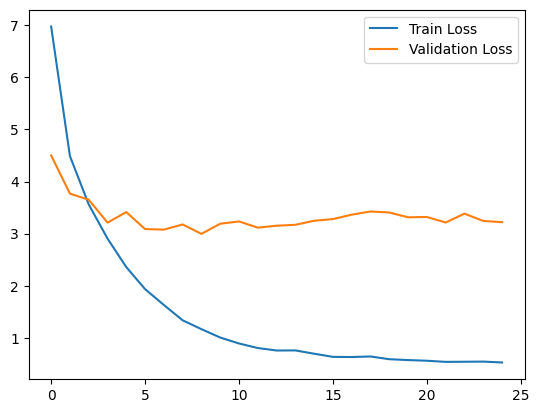

In [133]:
# plot the results
from matplotlib import pyplot as plt


plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()


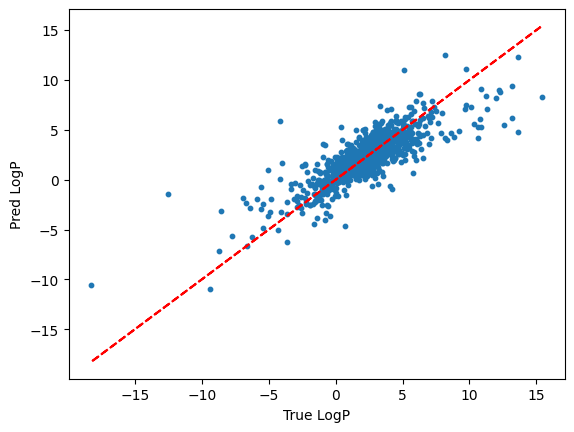

In [134]:
# test with the best model (with lowest validation loss)

# load model
model_fn = "./model_20.pt" # choose the best model
model.load_state_dict(torch.load(model_fn, map_location="cpu"))
model.cuda()
model.eval()

# make logp predictions
all_logps, all_pred_logps, all_smiles = [], [], []
with torch.no_grad():
    for batch_sample in test_loader:
        fp = batch_sample["fp"]
        logp = batch_sample["logp"]
        smiles_list = batch_sample["SMILES"]

        all_smiles += smiles_list
        all_logps += logp.cpu().tolist()

        pred_logp = model(fp.cuda()) #
        all_pred_logps += pred_logp.cpu().tolist()


import pandas as pd
from matplotlib import pyplot as plt


pd.DataFrame({"SMILES":all_smiles, "pred_logp":all_pred_logps, "logp":all_logps})
plt.scatter(all_logps, all_pred_logps, s=10)
plt.xlabel('True LogP')
plt.ylabel('Pred LogP')
plt.plot(all_logps, all_logps, label='y=x', color='red', linestyle='--')
# Display the plot
plt.show()

